In [1]:
import adddeps
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
from scipy.stats import norm,normaltest, probplot

import pandas as pd
import sqlalchemy
from collections import defaultdict
import datetime
import importlib
from simulator.magnetic import SimulatorMagnetic
from simulator.models import Client, SimulationAlchemy as Simulation
from tqdm.notebook import tqdm

import multiprocessing
from multiprocessing import Pool, cpu_count

from relaxation.estimators import relaxation_finder_collision
from utils.utils import smoothen, plot_mean_std, concat, df_round_time

import logging
import sys, os
import h5py

matplotlib.rcParams["figure.dpi"] = 150
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
client = Client()

In [ ]:
import logging

logging.config.fileConfig("/home/ashmat/telegramLogConfig")

logger = logging.getLogger("telegram")

logger.info("probe_diffusion analyse done!")

In [2]:
items = client.get_simulation_groups(["ER 3.303.weak.lammps"])[:]

In [2]:
items = client.get_simulation_groups(["ER 3.600.weak.lammps"])[:]

In [3]:
for item in tqdm(items):
    with h5py.File(item._hdf5_path, "r") as ds:
        item.Ltot = ds["total/L"][:]

  0%|          | 0/1560 [00:00<?, ?it/s]

In [4]:
for item in tqdm(items):
    item.dfLtot = pd.DataFrame({"time":np.arange(len(item.Ltot))*item.record_interval,
                               "L":item.Ltot})

  0%|          | 0/1560 [00:00<?, ?it/s]

In [8]:
item = items[0]
shift = 5000
a = (1/item.a + 1/item.b)/2
eps = (1/item.b - 1/item.a)/2/a
a, eps, item.eccentricity**2/4

(0.20000001305094345, 0.0003612608774673922, 0.000361)

In [6]:
df_L = pd.concat([smoothen(item.df[["L"]],-1).L for item in items],axis=1)
df_L.set_index(df_L.index-shift, inplace=True)

In [9]:
df_L = pd.concat([smoothen(item.dfLtot,-1).L for item in items],axis=1)
df_L.set_index(df_L.index-shift, inplace=True)

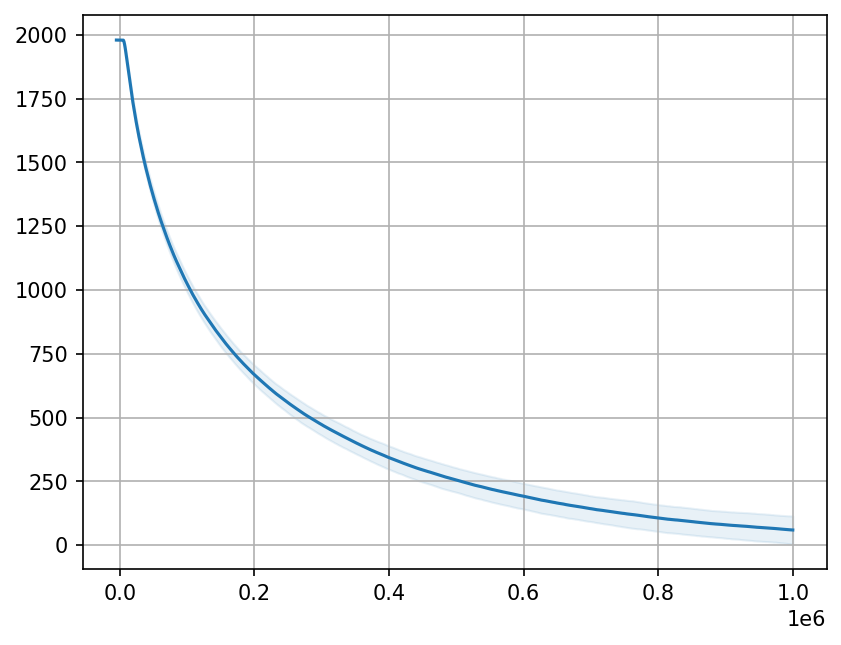

In [10]:
plot_mean_std(df_L.loc[:1000000])
plt.grid()
# plt.yscale("log")
# plt.ylim(1,600)
# plt.xlim(1000,2000)

In [8]:
df_L.iloc[-1].mean()

1673.8136810071974

In [9]:
df_E = pd.concat([smoothen(item.df[["E"]],-1).E for item in items],axis=1)
df_E.set_index(df_E.index-shift, inplace=True)

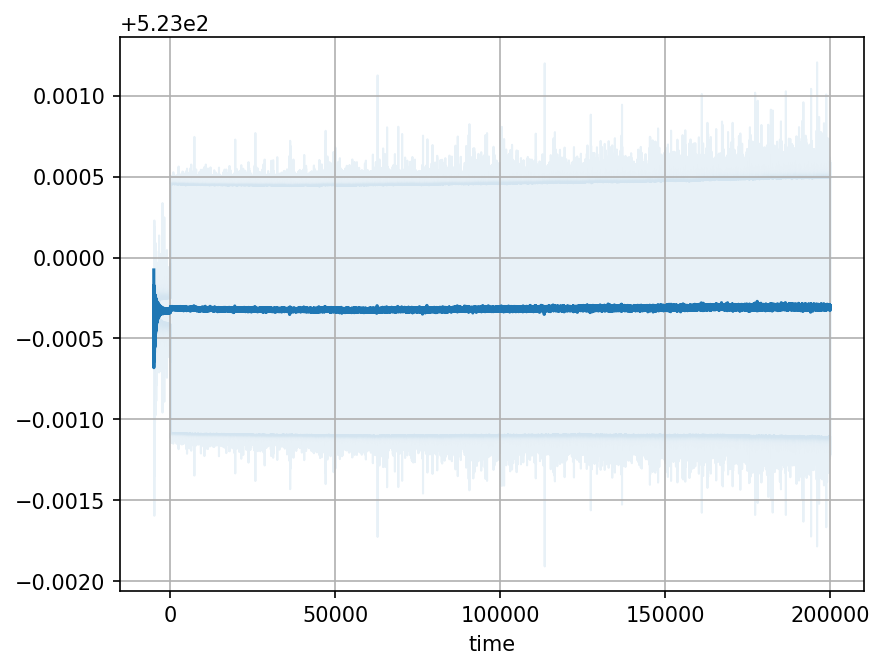

In [10]:
plot_mean_std(df_E.loc[:])
plt.grid()

In [19]:
df1 = df_L.loc[0:600000]
alpha,beta = np.polyfit(df1.index.values, np.log(df1.mean(axis=1).values),deg=1)
alpha, beta

(-6.212153036778294e-06, 7.145741377183315)

array([0.000000e+00, 5.000000e-01, 1.000000e+00, ..., 1.999990e+05,
       1.999995e+05, 2.000000e+05])

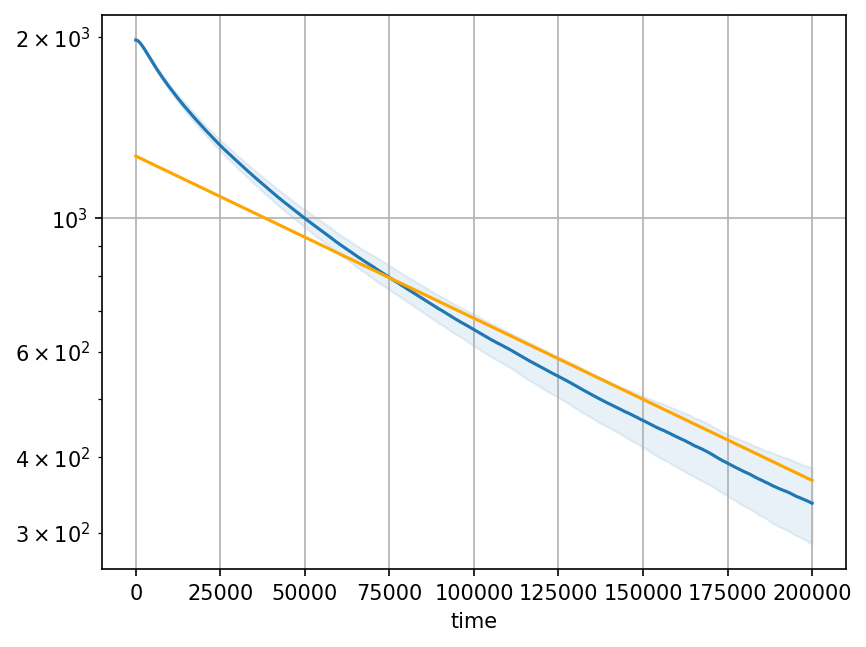

In [23]:
plot_mean_std(df_L.loc[0:200000])
ts = df_L.loc[0:200000].index.values
plt.plot(ts,np.exp(beta + alpha *ts), color="orange")
plt.grid()
plt.yscale("log")
# plt.ylim(1,600)
# plt.xlim(1000,2000)

In [19]:
0.0262 * (700/500)**(1/4)

0.028499241415556664

In [16]:
(262/445)**4 * 2.857

0.3433012318129216

In [ ]:
df_L.plot()

In [68]:
df_L.mean(axis=1)

-5000.0     1979.557615
-4999.8     1979.557615
-4999.6     1979.557615
-4999.4     1979.557615
-4999.2     1979.557615
               ...     
 59999.2      15.697704
 59999.4      15.696736
 59999.6      15.695780
 59999.8      15.694835
 60000.0      15.693902
Length: 325001, dtype: float64

<Axes: >

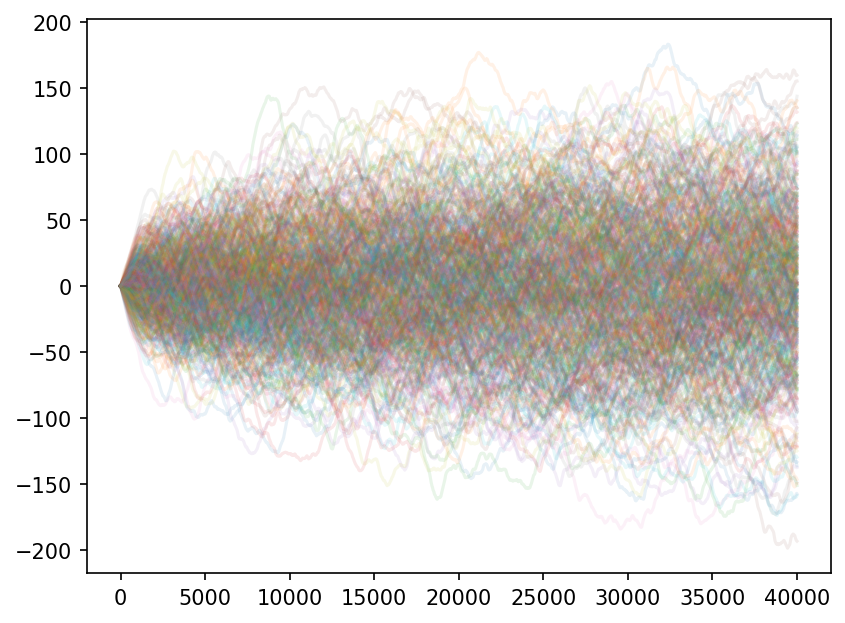

In [70]:
df_L.sub(df_L.mean(axis=1), axis=0).loc[0:40000:100].plot(alpha=0.1, legend=False)

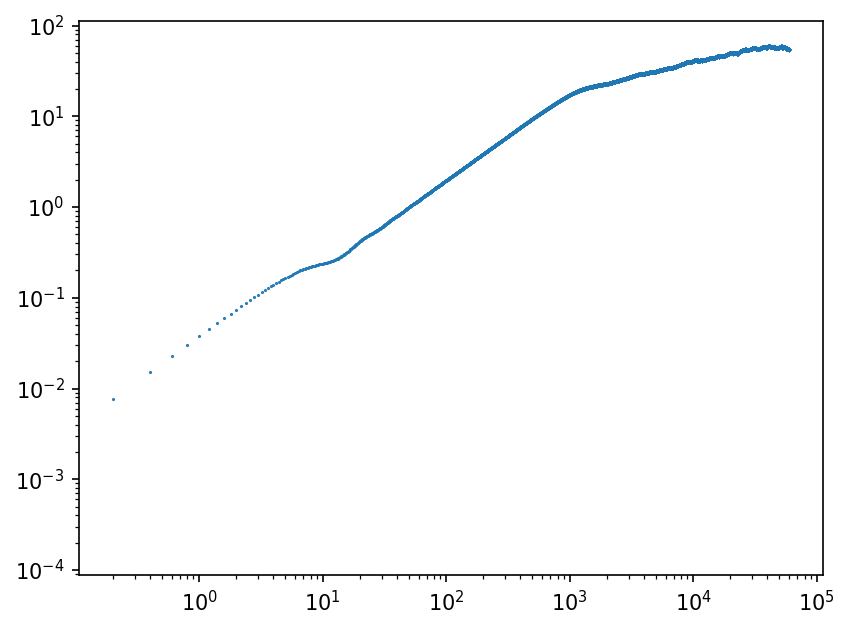

In [79]:
df_L.std(axis=1).plot(lw=0,marker=".",ms=1)
plt.yscale("log")
plt.xscale("log")

In [46]:
item.eccentricity

0.075

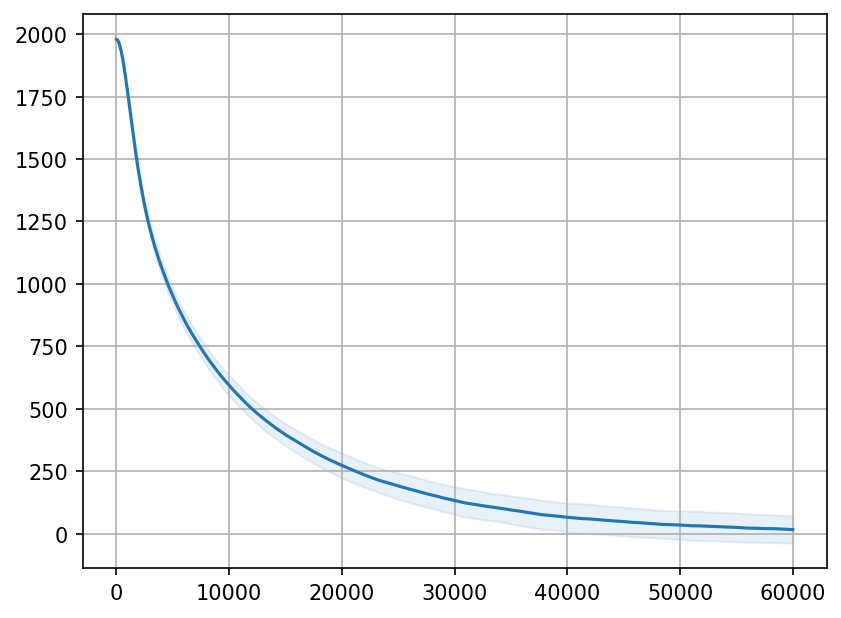

In [47]:
plot_mean_std(df_L.loc[0:])
plt.grid()
# plt.yscale("log")
# plt.ylim(0.1,300)

(0.20000019887207005, 0.0014102190376778555)

In [49]:
a*eps**2

1.5909789333929154e-08

array([-3.23328142e-05,  3.09479050e+00])

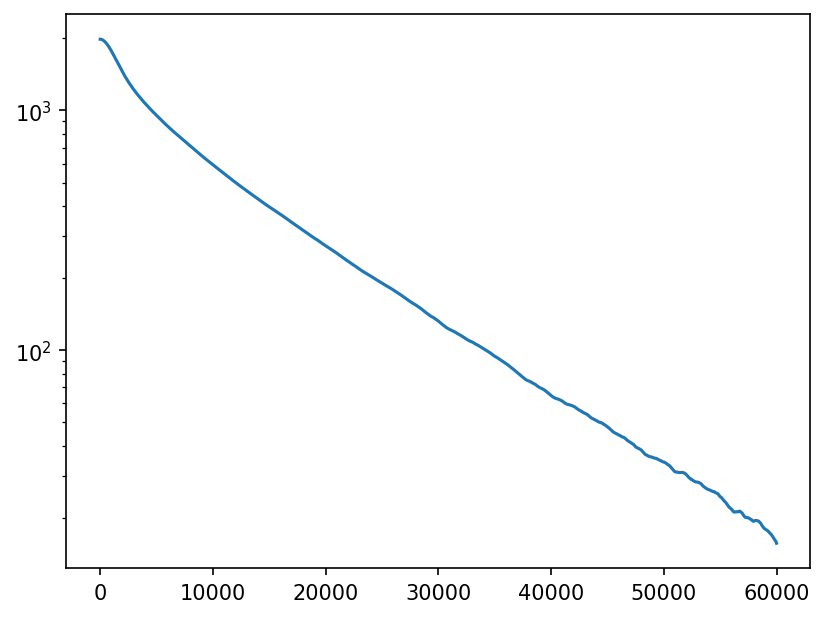

In [51]:
df_L.loc[0:].mean(axis=1).plot()
plt.yscale("log")
sr = df_L.loc[5000:40000].mean(axis=1)
np.polyfit(sr.index.values, np.log10(sr.values), deg=1)

In [206]:
df_xy = concat([df.xy for df in dfs])

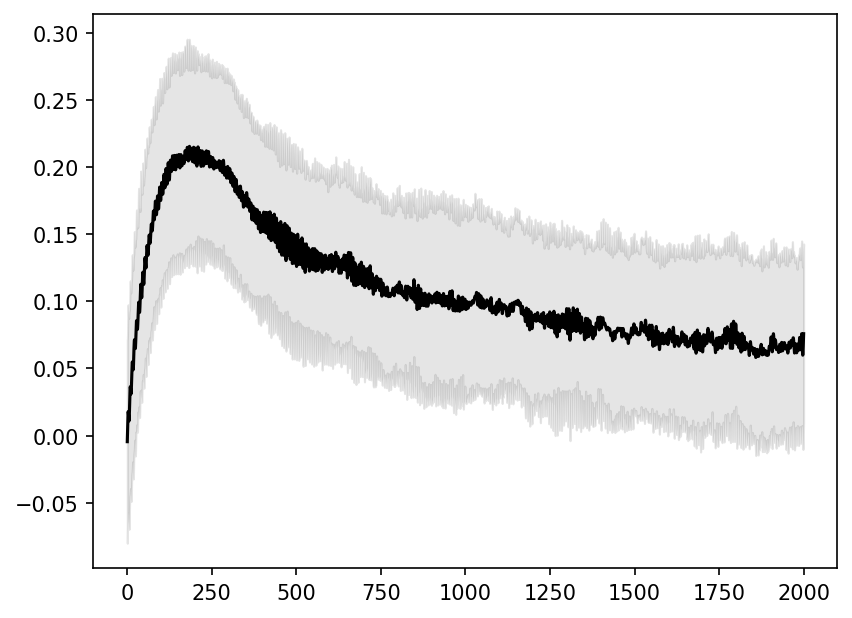

In [209]:
plot_mean_std(smoothen(df_xy,-1).loc[0:2000], "k","xy")

<Axes: >

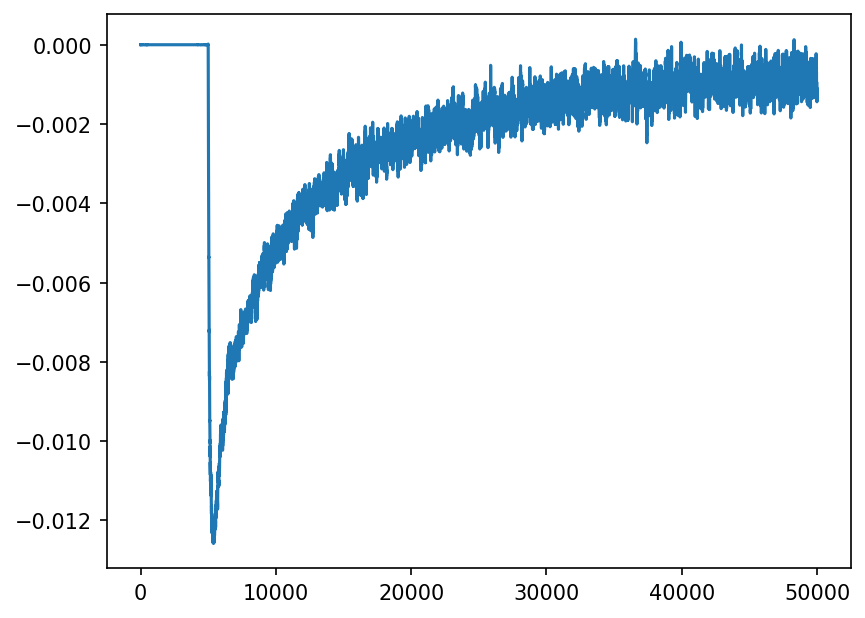

In [159]:
df_L = pd.concat([smoothen(item.df[["total_L"]],10).total_L for item in items],axis=1)
df_L.mean(axis=1).diff(1).plot()

In [160]:
df = smoothen(dfs[0],5)

In [161]:
df_omega = pd.concat([smoothen(df,1).omega_MLE for df in dfs],axis=1)

In [162]:
sr = df_omega.mean(axis=1).dropna()

(0.01, 1)

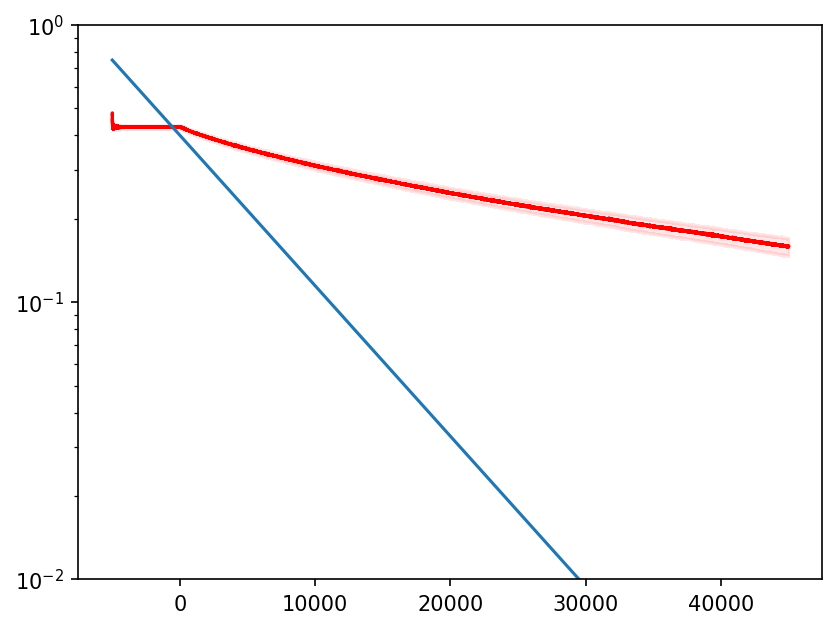

In [163]:
plot_mean_std(df_omega, "r", "")
ts = df_omega.index.values
plt.plot(ts, 0.4* np.exp(-ts/8000))
plt.yscale("log")
plt.ylim(0.01, 1)

<Axes: >

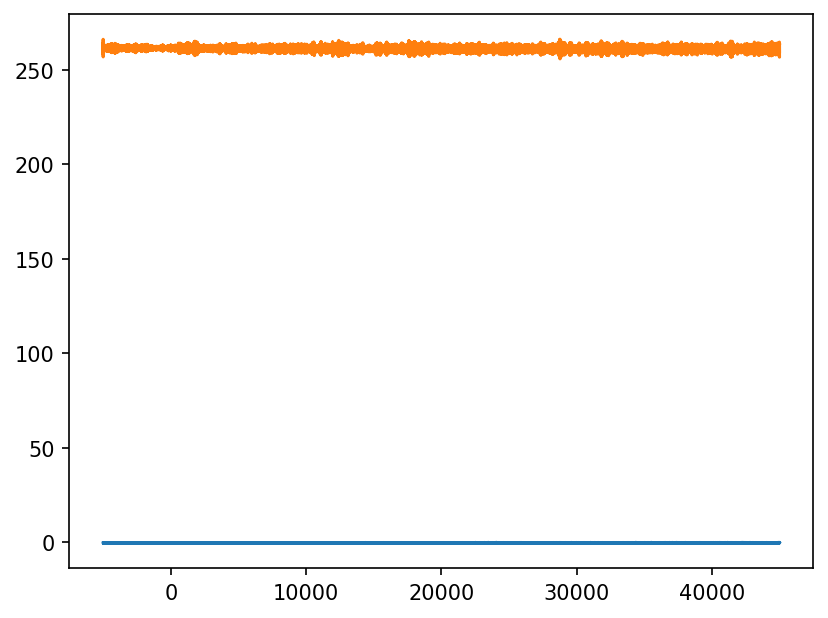

In [164]:
df.total_IE.plot()
df.total_KE.plot()

In [165]:
a = (item.a+item.b)/2
eccentricity = item.eccentricity
eps = eccentricity**2/4

In [166]:
eps

0.0010562500000000001

<Axes: >

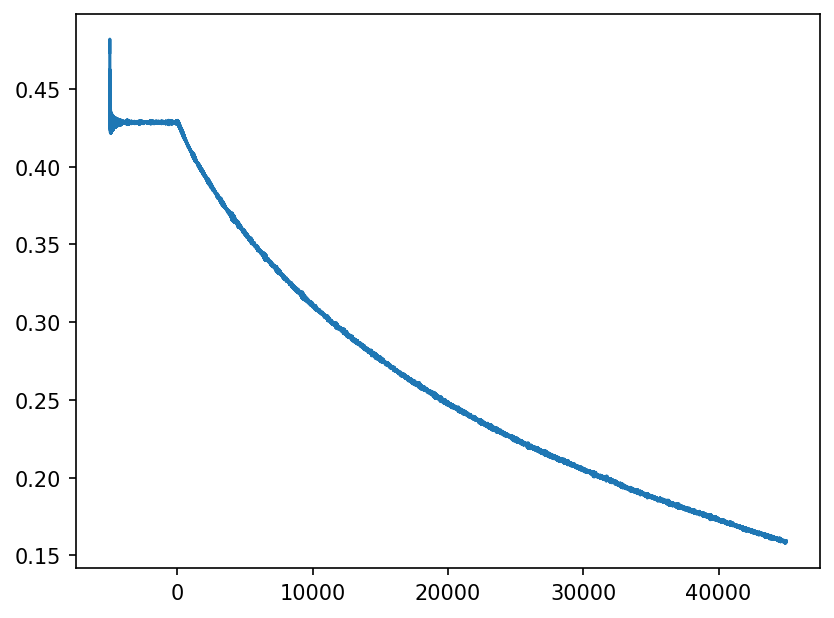

In [167]:
df_omega.mean(axis=1).plot()

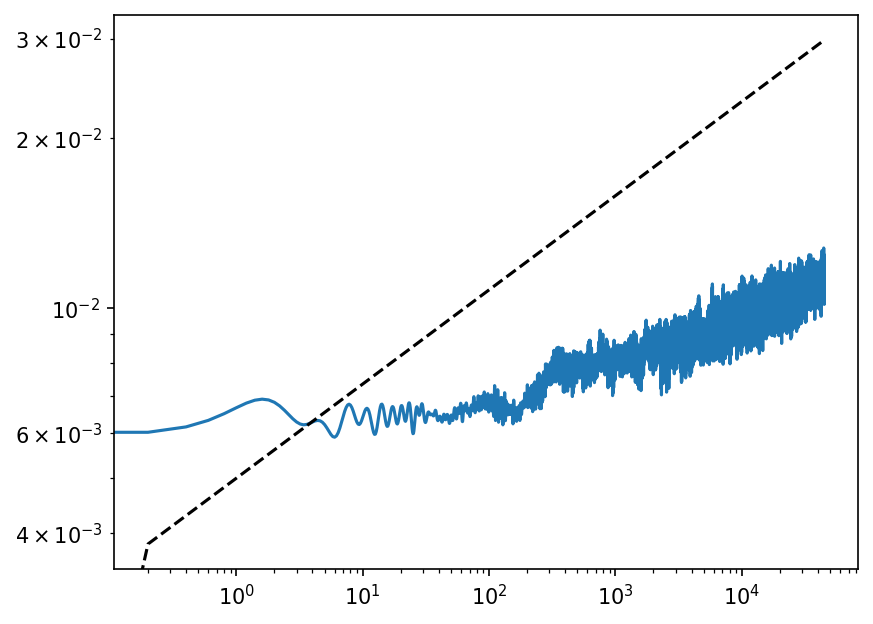

In [168]:
df_omega.loc[0:].std(axis=1).plot()
ts = df_omega.loc[0:].index.values
plt.plot(ts, 0.005 * ts**(1/6), "--", c="k")
plt.xscale("log")
plt.yscale("log")


## beta-omega test

In [169]:
[df.total_E[-1]/df.total_E[0] for df in dfs]

[1.000001210798802,
 1.0000007238519126,
 0.999999013202339,
 1.0000003597236484,
 0.9999990760654797,
 1.000000050061976,
 0.9999968498489814,
 0.999999261552859,
 1.0000002851604912,
 1.0000005617468688,
 1.0000007095734649,
 1.0000000993200318,
 1.0000001505111995,
 1.0000018771299475,
 0.9999997199667202,
 0.999999832030627,
 0.9999990941887902,
 0.9999970371713296,
 0.999997678530617,
 0.9999999410655785,
 0.9999994616378108,
 1.0000030198340972,
 1.0000005666130276,
 0.9999976586384496,
 1.0000002935372825,
 0.9999987294667609,
 1.000000631045471,
 0.9999998702563817,
 1.0000014623796438,
 0.9999997643408235,
 1.0000010743639374,
 1.000000252227263,
 0.9999998269986728,
 0.9999987247864899,
 0.9999994878160472,
 1.00000102479958,
 1.0000007631436791,
 1.0000005550228586,
 0.9999993077008217,
 0.999999601817908,
 1.0000001246667451,
 1.0000009197687285,
 0.9999997725395425,
 1.0000030277875562,
 0.9999999381216498,
 1.0000002385328404,
 1.0000004893661973,
 0.999998068804631,
 0.9

In [170]:
dfs0 = dfs

In [171]:
len(dfs0)

197

In [62]:
df = dfs[0]
N = item.particles
df_L = concat([df.L for df in dfs])
df_T = concat([1/df.beta_MLE for df in dfs])
df_beta = concat([df.beta_MLE for df in dfs])
df_omega = concat([df.omega_MLE for df in dfs])
# df_xy = smoothen(concat([df.xy for df in dfs]),-1)

# df_zz = concat([df.zz for df in dfs])

# df_IE = smoothen(concat([df["total_IE"] for df in dfs]),-1)
                 
# df_KPE = concat([df["total_E"]-df["total_IE"] for df in dfs])

# df_KE = concat([df["total_KE"] for df in dfs])

In [64]:
def f_beta(x):
    x = np.abs(x)
    return 3 * (1 - x**2)/(2 + np.sqrt(1 + 3 * x**2))
def f_omega(x):
    x = np.abs(x)
    return np.sqrt(1 + 3 * x**2) - 1

a = (item.a + item.b)/2

wind = 30
omega_arr = smoothen(df_omega, wind).dropna().loc[0:].values.flatten()
L_arr = smoothen(df_L, wind).dropna().loc[0:].values.flatten()
beta_arr = smoothen(df_beta, wind).dropna().loc[0:].values.flatten()

E = dfs[0].E.loc[100]

df0 = pd.DataFrame(
    {"x":1/a * L_arr / E,
     "y_beta": 3 * N/E/beta_arr,
     "y_omega": omega_arr * L_arr / E}
)

In [65]:
df = df0.loc[::1000]

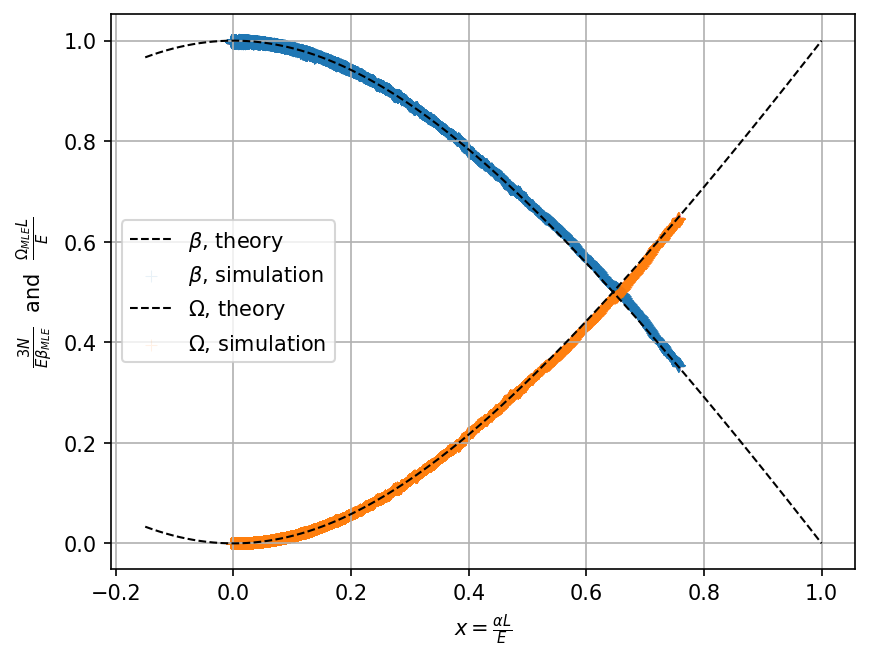

In [66]:
xs = np.linspace(-0.15,1,200)
alpha=0.1
plt.plot(xs, f_beta(xs), "k--", lw=1, label=r"$\beta$, theory")
plt.scatter(df["x"], df["y_beta"], marker="+", s=30,lw=0.5, alpha=alpha, label=r"$\beta$, simulation")

plt.plot(xs, f_omega(xs), "k--", lw=1, label="$\Omega$, theory")
plt.scatter(df["x"], df["y_omega"], marker="+", s=30,lw=0.5, alpha=alpha, label=r"$\Omega$, simulation")


plt.xlabel(r"$x=\frac{\alpha L}{E}$")

plt.ylabel(r"$\frac{3 N}{ E \beta_{MLE} }$  and  $\frac{\Omega_{MLE} L}{E}$")
plt.legend()
plt.grid()

In [176]:
len(dfs)

197

In [70]:
df = dfs[0]

In [71]:
df.head()

,N,Iz,xx,yy,zz,xy,omega_MLE,beta_MLE,total_L,total_E,total_KE,total_IE,collisions-1,collisions-2,collisions-3
time,,,,,,,,,,,,,,,
-5000.0,273.0,225.166687,0.417277,0.407509,0.023199,0.000000,0.940323,38.077454,211.729492,273.000000,110.301491,-0.543609,0.0,0.0,0.0
-4999.9,273.0,225.842010,0.415879,0.411381,0.019597,0.001357,0.937512,21.836992,211.729492,271.734070,118.001999,-0.711287,0.0,0.0,0.0
-4999.8,273.0,226.241577,0.413799,0.414925,0.011588,0.002179,0.935856,11.010442,211.729492,271.734009,136.266098,-1.680549,0.0,0.0,0.0
-4999.7,273.0,226.420654,0.411246,0.418133,0.004168,0.002486,0.935116,7.585961,211.729492,271.732300,152.977066,-2.277013,58.0,40.0,28.0
-4999.6,273.0,227.037659,0.409296,0.422344,0.002433,0.002162,0.932574,6.925149,211.729492,271.733643,157.859039,-3.672803,266.0,282.0,266.0


<Axes: xlabel='time'>

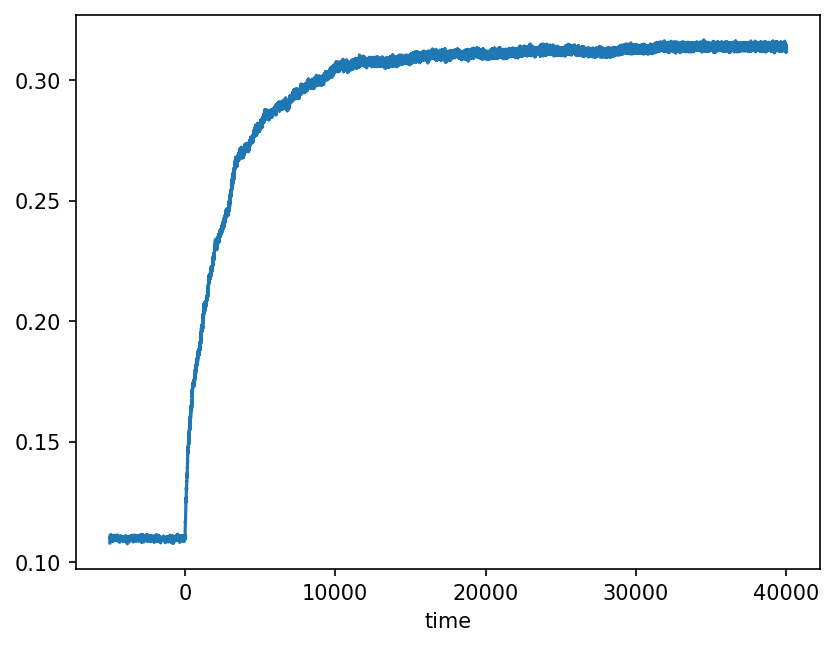

In [76]:
smoothen(df["beta_MLE"]**-1, 10).plot()

In [77]:
0.1/(1-0.8**2)

0.2777777777777779

<Axes: xlabel='time'>

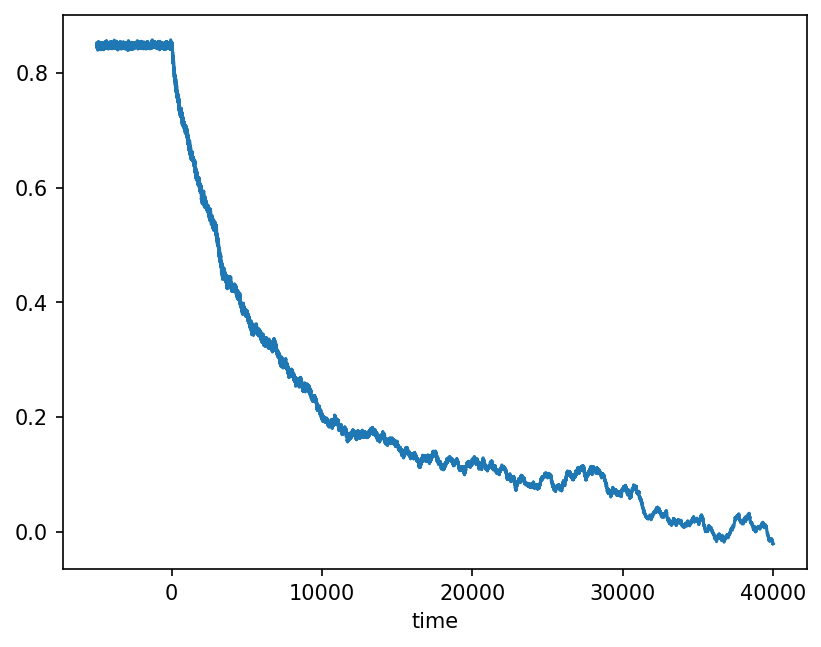

In [75]:
smoothen(df["omega_MLE"], 10).plot()

<Axes: xlabel='time'>

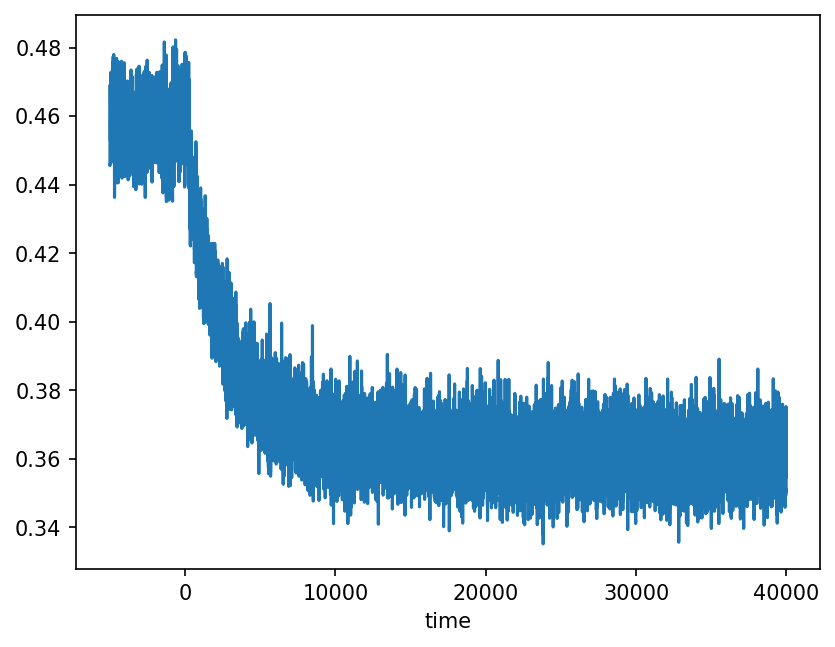

In [74]:
smoothen(df["xx"], 10).plot()

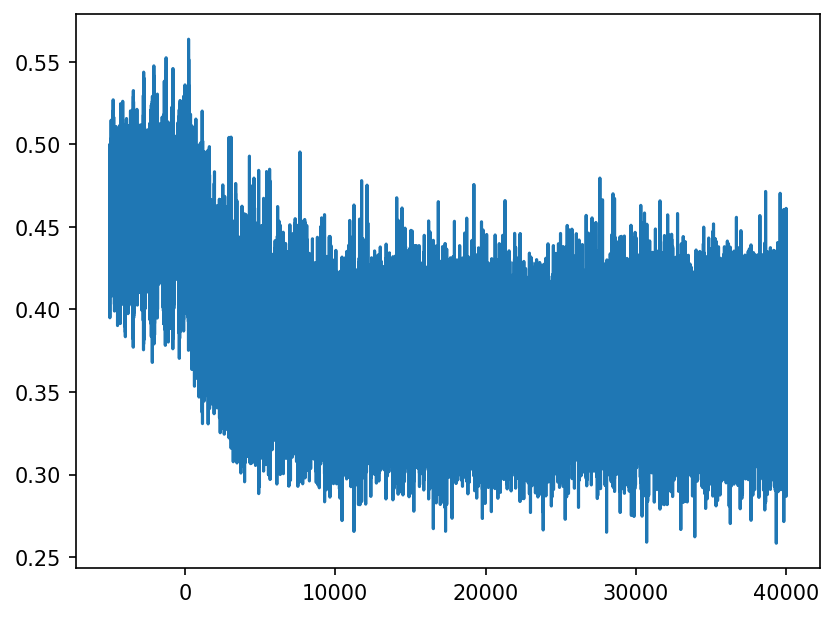

In [72]:
plt.plot(df["xx"])

In [272]:
item.hash

'd7212fc05267934f'

## Export data

In [67]:
dfs[0]

,,E,IE,KE,L,PE,beta_MLE,omega_MLE,vxvx,vxvy,vyvy,vzvz,xx,xy,yy,zz
-5000.0,0.0,522.999929,0.000000,206.919175,1979.557649,316.080754,38.885498,0.188673,0.382996,0.003425,0.382486,0.025795,10.030596,4.288051e-17,10.030593,0.634799
-4999.8,0.2,522.999928,0.000000,209.008390,1979.557649,313.991539,35.088397,0.188578,0.382740,0.003431,0.382338,0.034189,10.036990,-1.505332e-04,10.034300,0.621684
-4999.6,0.4,522.999927,0.000000,215.957146,1979.557649,307.042782,26.708746,0.188512,0.382544,0.003426,0.382251,0.061045,10.041886,-2.623941e-05,10.036485,0.579721
-4999.4,0.6,522.999925,0.000000,227.052895,1979.557649,295.947030,19.367760,0.188474,0.382410,0.003410,0.382225,0.103636,10.045252,3.720864e-04,10.037135,0.513172
-4999.2,0.8,522.999910,-0.000247,241.165211,1979.557649,281.834823,14.361200,0.188465,0.382337,0.003383,0.382261,0.157640,10.047067,1.041896e-03,10.036244,0.428792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59999.2,64999.2,522.989034,-0.005948,252.889656,1.901332,270.102352,3.102146,0.000210,0.312844,0.014497,0.319822,0.334408,8.497752,1.977890e-01,8.794358,0.533087
59999.4,64999.4,522.989058,-0.032595,252.273362,1.896541,270.731994,3.109724,0.000209,0.312762,0.014008,0.318772,0.333182,8.500199,2.083431e-01,8.820651,0.535049
59999.6,64999.6,522.989046,-0.017113,251.810948,1.891494,271.186655,3.115435,0.000209,0.312862,0.013543,0.317823,0.332263,8.500539,2.193527e-01,8.844140,0.536272
59999.8,64999.8,522.989063,-0.028076,251.560262,1.886184,271.442839,3.118539,0.000208,0.312921,0.013110,0.317046,0.332023,8.498779,2.307441e-01,8.864674,0.536625


In [68]:
# export data
df = dfs[0]
N = item.particles
# N = int(df["N"].iloc[0])

df_L = concat([df.L for df in dfs])
df_T = concat([1/df.beta_MLE for df in dfs])
df_omega = concat([df.omega_MLE for df in dfs])
df_xy = smoothen(concat([df.xy for df in dfs]),-1)

df_zz = concat([df.zz for df in dfs])

df_IE = smoothen(concat([df["IE"] for df in dfs]),-1)
                 
df_KPE = concat([df["E"]-df["IE"] for df in dfs])

df_KE = concat([df["KE"] for df in dfs])




df_exported = pd.DataFrame({
    "O":df_omega.mean(axis=1).loc[0:],
    "L":df_L.mean(axis=1).loc[0:],
    "xy":df_xy.mean(axis=1).loc[0:],
    "T":df_T.mean(axis=1).loc[0:],
    "zz":df_zz.mean(axis=1).loc[0:],
    "E":df_KPE.mean(axis=1).loc[0:],
    "K":df_KE.mean(axis=1).loc[0:],
}
).to_hdf(f"{N}-relaxed.h5", key="/df")

with h5py.File(f"{N}-relaxed.h5", "r+") as f:
    f.attrs["particles"] = item.particles
    f.attrs["ax"], f.attrs["ay"], f.attrs["az"] = 1/item.a, 1/item.b, 1/item.c
    
    print(f.attrs.keys())

<KeysViewHDF5 ['CLASS', 'PYTABLES_FORMAT_VERSION', 'TITLE', 'VERSION', 'ax', 'ay', 'az', 'particles']>


In [41]:
N

343

In [221]:
1/item.a, 1/item.b, 1/item.c

(0.49874528496684056, 0.5012578715739066, 2.0)

In [222]:
df_T.mean(axis=1).loc[0:]

0.0        0.117021
0.2        0.117230
0.4        0.117340
0.6        0.117338
0.8        0.117214
             ...   
44999.2    0.332364
44999.4    0.332104
44999.6    0.332060
44999.8    0.332282
45000.0    0.332730
Length: 225001, dtype: float64

In [239]:
df_omega.mean(axis=1)

-5000.0     0.471682
-4999.8     0.471857
-4999.6     0.472462
-4999.4     0.473472
-4999.2     0.474817
              ...   
 44999.2    0.010663
 44999.4    0.010659
 44999.6    0.010655
 44999.8    0.010651
 45000.0    0.010647
Length: 250001, dtype: float64